In [1]:
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from supDem import *
from rollingHorizon import *
from plotRes import *

# Supply and Demand

In [2]:
dfDemand,s_others_yearly,e_others_yearly=SupDem(save=False)
indSupply,indDemand=indSupDem(dfDemand,s_others_yearly,e_others_yearly)

Adjusted number of community panels to: 32000


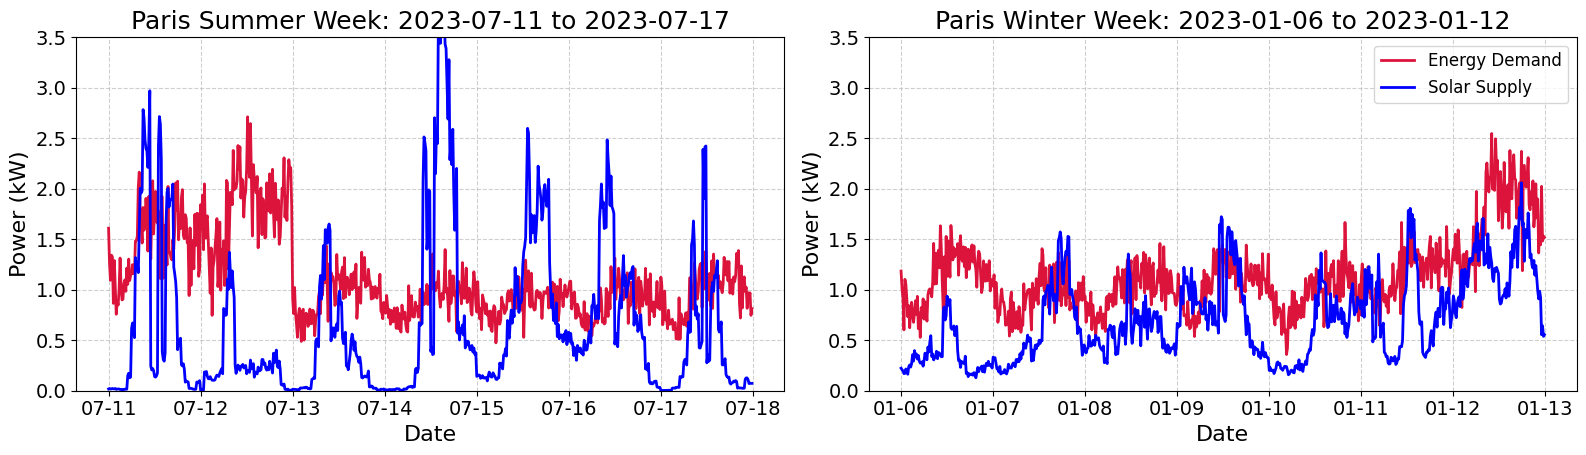

In [3]:
plotSummerWeek(indDemand,indSupply,start_date_summer = '2023-07-11',end_date_summer = '2023-07-17')


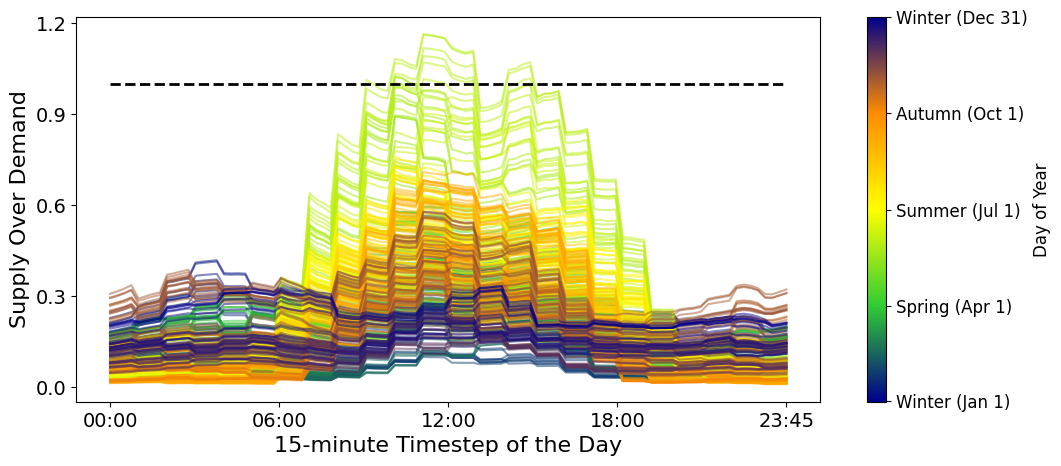

In [4]:
plotSD(dfDemand,s_others_yearly, e_others_yearly)

# Prosumer-Level Gains from Decentralization

In [5]:
simulation_index = indDemand.index
indDemand = pd.DataFrame(indDemand)
indDemand.columns = ['demand_kw']
individual_demand_profile=pd.read_csv('data/individual_demand_profile.csv', index_col=0, parse_dates=True)
new_demand_profile = generate_night_owl_profile(base_index=simulation_index,)

# Assuming prosumer's generation is from the individual supply profile
omega_yearly = pd.read_csv('data/individual_supply_profile.csv', index_col=0, parse_dates=True)
omega_yearly.columns = ['supply_kw'] # Rename column for clarity

# Remove timezone information to make all datetime indices compatible
s_others_yearlyT = pd.DataFrame(s_others_yearly)
s_others_yearlyT.index = s_others_yearly.index.tz_localize(None)
s_others_yearlyT.columns = ['supply_kw']
s_others_yearlyT["supply_kw"]=s_others_yearlyT["supply_kw"].values+e_others_yearly.values
omega_yearly.index = omega_yearly.index.tz_localize(None)

dfDemand.columns = ['demand_kw']
# 2. Set alpha_base as 75% of individual demand (this is a timeseries)
pct_flex    = 0.3   ## PCT of flex consumption need
alpha_base_yearly = (1-pct_flex)* new_demand_profile['demand_kw']



# 3. Define Simulation Parameters
# Prosumer parameters
B           = 10.0  ## BATTERY CAPACITY (BATTERY STORES PUT TO B kw)
b0_initial  = 5.0   ## INITIAL BATTERY STATE
X           = 5.0   ## MAXIMUM ENERGY TRANSACTION WITH THE GRID PER TIME UNIT
K_max       = 5.0   ## MAXIMUM BATTERY CHARGE/DISCHARGE POWER (in kW)
TotalDays = 360
L_input = 4      # Fixed lookahead window
T = 24 * 4       # Time steps per day (15-minute intervals)
gamma_day = 0.99     # Epoch discount rate
gamma_hourly = gamma_day**(1/T)
hours = np.arange(0,24,24/T)
hourCreusePleine =['c','c','c','c','c','c',
                   'p','p','p','p','p','p',
                   'c',
                   'p','p','p','p','p','p','p','p','p','p',
                   'c',]
HP=0.2146
HC=0.1696
lamOverPrice=0.0886
lam_under = np.full(T, lamOverPrice)
lam_over  = np.ones(T,)
for j in range(T):
    if hourCreusePleine[floor(hours[j])]=='p':lam_over[j]=HP
    else: lam_over[j]=HC
alpha_base_yearly_T = np.zeros((360,L_input+1))
unique_days = (indDemand['demand_kw']).index.normalize().unique()
sim_days_slice = slice(unique_days[0], unique_days[TotalDays-1] + pd.Timedelta(days=1) - pd.Timedelta(minutes=15))
alpha_base_daily = indDemand['demand_kw'].loc[sim_days_slice].values.reshape(TotalDays, T)*(1-pct_flex)
alpha_flex_day = np.sum(alpha_base_daily,1)*pct_flex/(1-pct_flex)


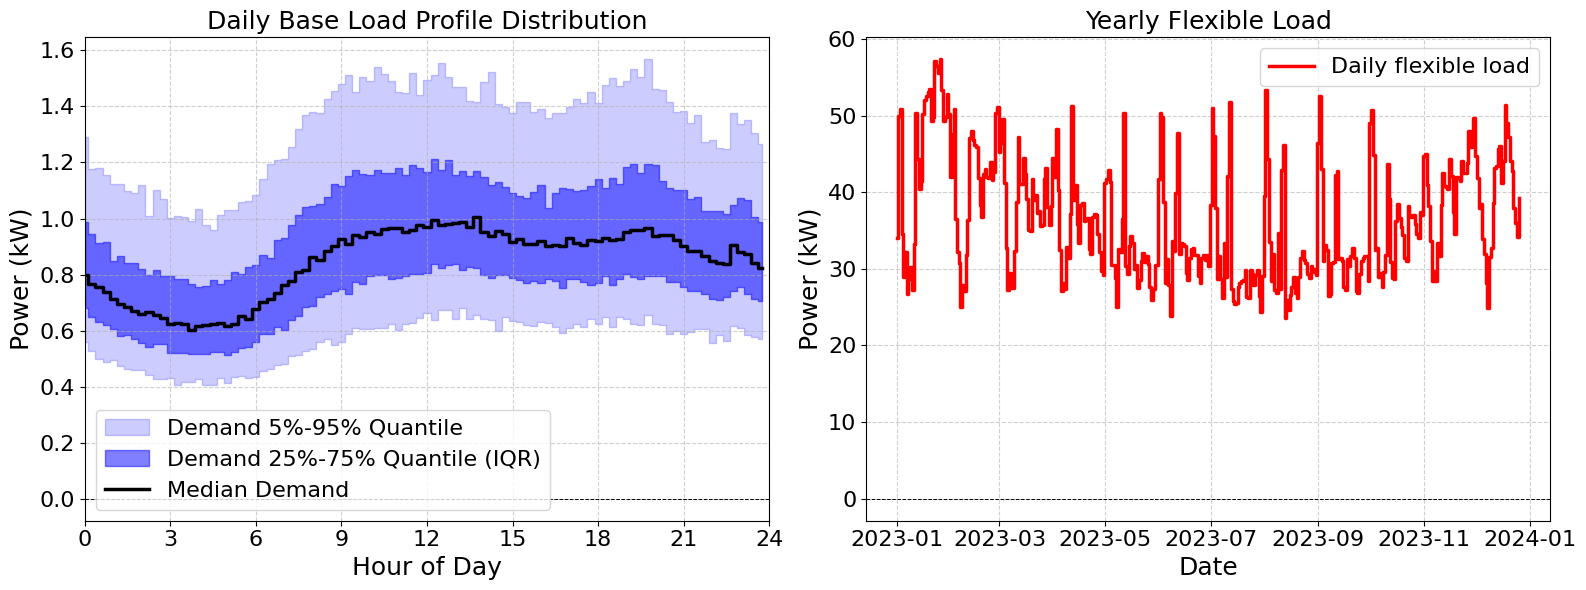

In [6]:
plotBaseFlexLoad(T,alpha_base_daily,unique_days,alpha_flex_day)

In [11]:
try:
    RHresults=pd.read_csv('data/simulation_results.csv')
except:
    RHresults=runRH(T,360,alpha_base_yearly,b0_initial,L_input,
          omega_yearly,s_others_yearlyT,dfDemand,
          new_demand_profile,pct_flex,alpha_base_yearly_T,
          B, X, K_max,
          lam_under, lam_over, gamma_hourly,
          individual_demand_profile
          )
k_dayT = RHresults['battery_charge_discharge_kw'].values.reshape(TotalDays, T)
xnet_dayT = RHresults['net_grid_trade_kw'].values.reshape(TotalDays, T)
soc_dayT = RHresults['battery_soc_kwh'].values.reshape(TotalDays, T)

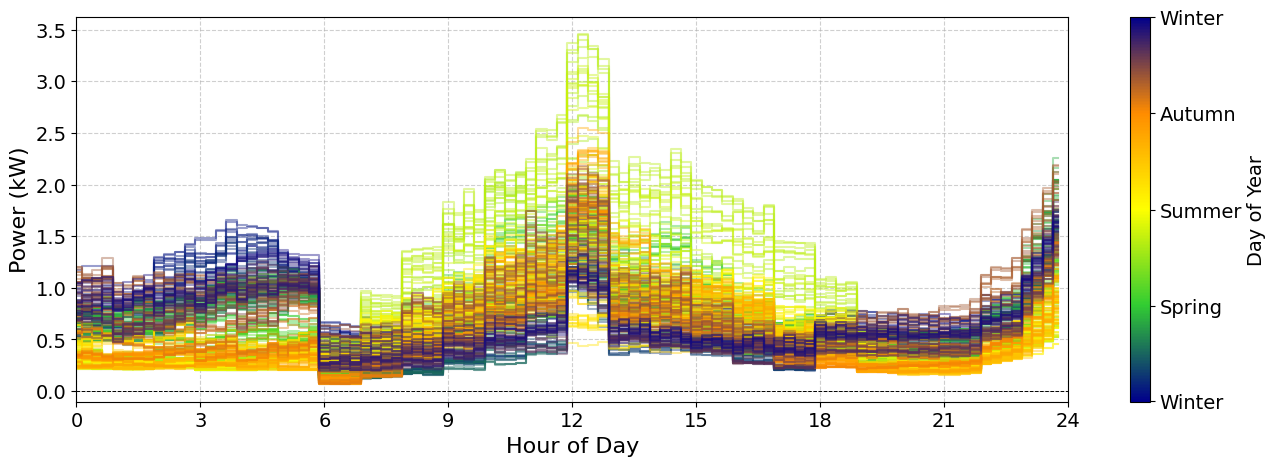

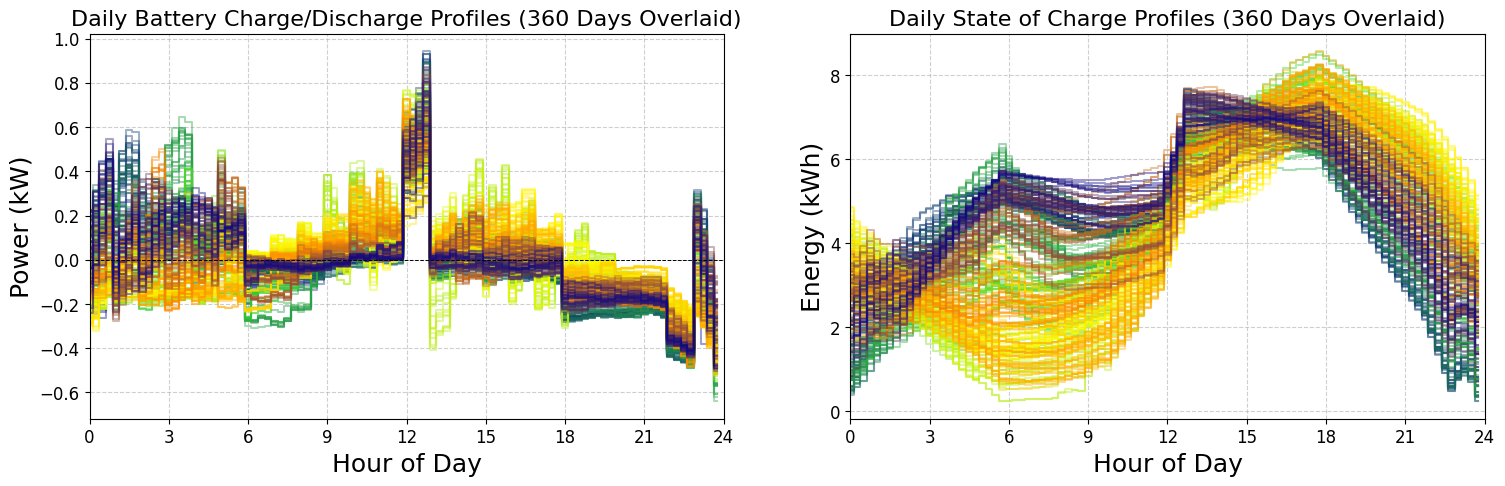

In [12]:
plotGridRes(T,k_dayT,xnet_dayT,soc_dayT,unique_days,TotalDays,omega_yearly)

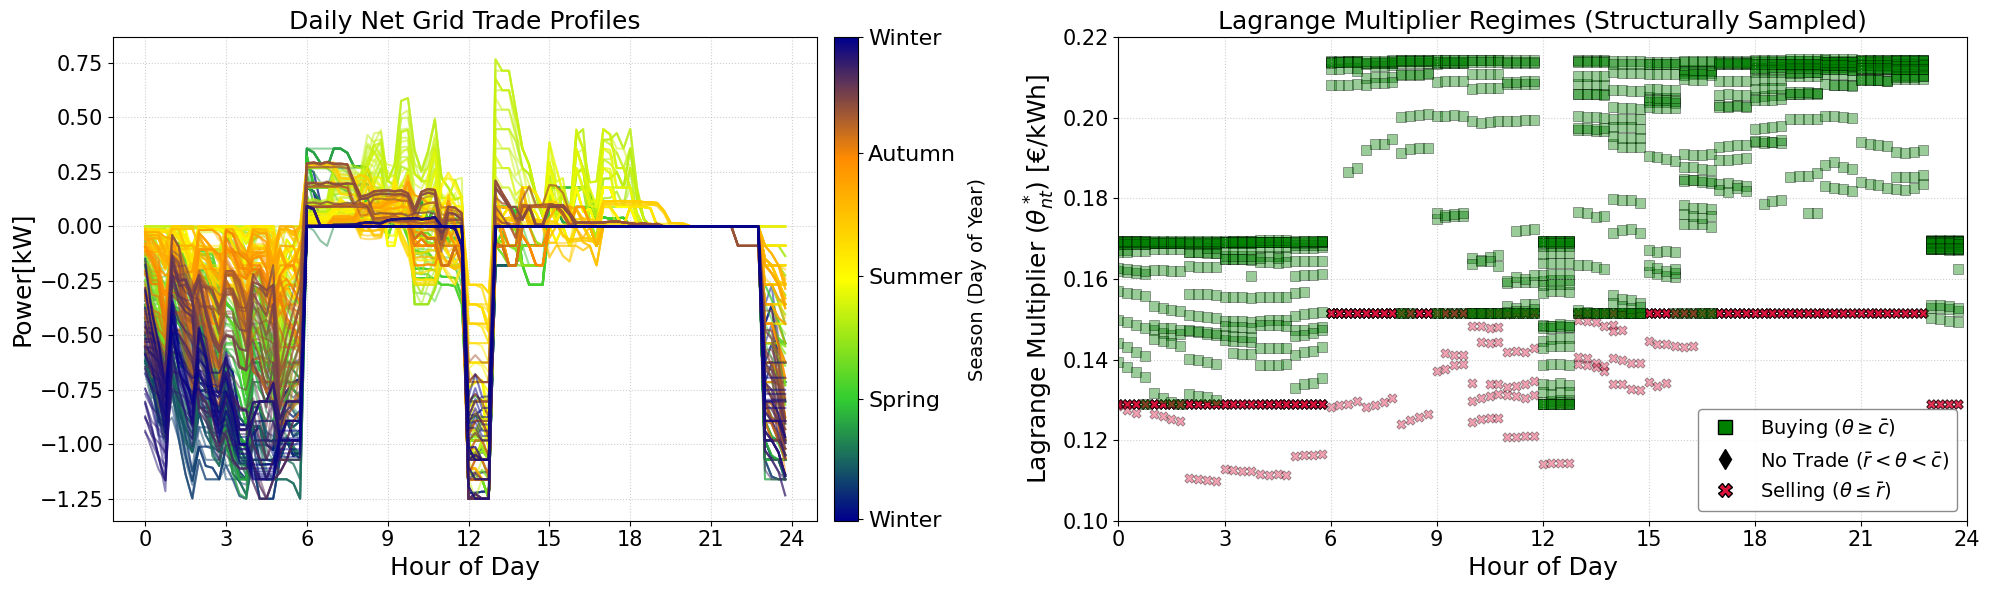

In [13]:
t_daily = np.arange(0, 24, 24 / T) # Time axis for a single day
plotLag(RHresults,xnet_dayT,t_daily)